In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Capstone/Food ingredients.v1i.tensorflow.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical


In [ ]:
annotations_path = '/content/dataset/train/_annotations.csv'  # Path to your annotations CSV
images_path = '/content/dataset/train/'  # Directory containing images

annotations = pd.read_csv(annotations_path)

target_size = (224, 224)

def load_and_preprocess_image(img_path, bbox, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    return img, bbox

def parse_annotation(row):
    img_path = os.path.join(images_path, row['filename'])
    xmin = row['xmin'] / row['width']
    ymin = row['ymin'] / row['height']
    xmax = row['xmax'] / row['width']
    ymax = row['ymax'] / row['height']
    bbox = [xmin, ymin, xmax, ymax]
    class_id = row['class']
    return img_path, bbox, class_id

annotations['img_path'], annotations['bbox'], annotations['class_id'] = zip(*annotations.apply(parse_annotation, axis=1))

# Split the dataset
train_annotations, test_annotations = train_test_split(annotations, test_size=0.2, random_state=42)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Create dataset function
def create_dataset(annotations, target_size, batch_size=32, augment=False):
    def gen():
        for index, row in annotations.iterrows():
            img_path = row['img_path']
            bbox = row['bbox']
            class_id = row['class_id']
            yield img_path, bbox, class_id

    def load_and_preprocess_from_path_label(img_path, bbox, class_id):
        img, bbox = load_and_preprocess_image(img_path.numpy().decode(), bbox, target_size)
        if augment:
            img = datagen.random_transform(img)
        return img, tf.one_hot(class_id, depth=len(annotations['class_id'].unique())), bbox

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(4,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )
    dataset = dataset.map(lambda img_path, bbox, class_id: tf.py_function(
        load_and_preprocess_from_path_label, [img_path, bbox, class_id],
        [tf.float32, tf.float32, tf.float32]
    ), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, class_id, bbox: (img, {'class_output': class_id, 'bbox_output': bbox}), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Creating datasets
batch_size = 32
train_dataset = create_dataset(train_annotations, target_size, batch_size, augment=True).repeat()
test_dataset = create_dataset(test_annotations, target_size, batch_size, augment=False).repeat()


In [ ]:
# Model definition
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout

# Bounding box regression
bbox_output = Dense(4, activation='sigmoid', name='bbox_output', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Adding L2 regularization

# Classification output
class_output = Dense(len(annotations['class_id'].unique()), activation='softmax', name='class_output', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Adding L2 regularization

model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

for layer in base_model.layers:
    layer.trainable = False


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': ['accuracy'], 'bbox_output': ['mse']},
              run_eagerly=True)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    steps_per_epoch=len(train_annotations) // batch_size,
                    validation_steps=len(test_annotations) // batch_size)

Epoch 1/10
560/560 [==============================] - 212s 362ms/step - loss: 0.2758 - class_output_loss: 0.2391 - bbox_output_loss: 0.0367 - class_output_accuracy: 0.9358 - bbox_output_mse: 0.0367 - val_loss: 0.0927 - val_class_output_loss: 0.0627 - val_bbox_output_loss: 0.0301 - val_class_output_accuracy: 0.9844 - val_bbox_output_mse: 0.0301
Epoch 2/10
560/560 [==============================] - 193s 345ms/step - loss: 0.0829 - class_output_loss: 0.0541 - bbox_output_loss: 0.0288 - class_output_accuracy: 0.9880 - bbox_output_mse: 0.0288 - val_loss: 0.0691 - val_class_output_loss: 0.0409 - val_bbox_output_loss: 0.0282 - val_class_output_accuracy: 0.9888 - val_bbox_output_mse: 0.0282
Epoch 3/10
560/560 [==============================] - 184s 328ms/step - loss: 0.0619 - class_output_loss: 0.0344 - bbox_output_loss: 0.0275 - class_output_accuracy: 0.9922 - bbox_output_mse: 0.0275 - val_loss: 0.0620 - val_class_output_loss: 0.0342 - val_bbox_output_loss: 0.0278 - val_class_output_accuracy:

dict_keys(['loss', 'class_output_loss', 'bbox_output_loss', 'class_output_accuracy', 'bbox_output_mse', 'val_loss', 'val_class_output_loss', 'val_bbox_output_loss', 'val_class_output_accuracy', 'val_bbox_output_mse'])


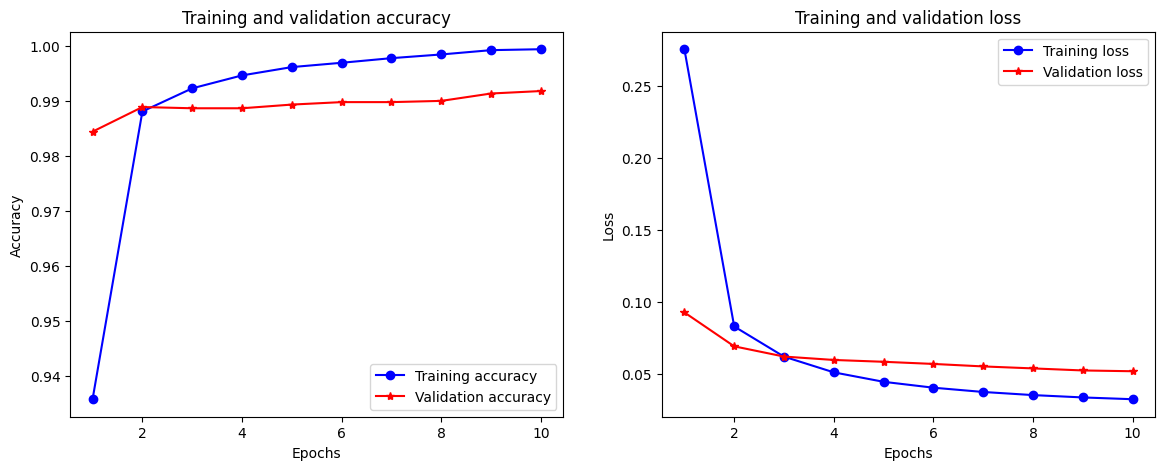

In [ ]:
import matplotlib.pyplot as plt

# Print the keys to see what metrics are available
print(history.history.keys())

# Extract the values from the history object
class_acc = history.history.get('class_output_accuracy')
val_class_acc = history.history.get('val_class_output_accuracy')
bbox_loss = history.history.get('bbox_output_loss')
val_bbox_loss = history.history.get('val_bbox_output_loss')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(loss) + 1)

# Plotting the training and validation accuracy
plt.figure(figsize=(14, 5))

if class_acc is not None and val_class_acc is not None:
    plt.subplot(1, 2, 1)
    plt.plot(epochs, class_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_class_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
batch_size = 32  # set your batch size
steps = 312  # set a fixed number of steps based on your estimation

results = model.evaluate(test_dataset, steps=steps)
print("Test Loss, Test Class Loss, Test Bbox Loss, Test Class Accuracy, Test Bbox MSE:", results)


312/312 [==============================] - 59s 188ms/step - loss: 0.0530 - class_output_loss: 0.0255 - bbox_output_loss: 0.0275 - class_output_accuracy: 0.9917 - bbox_output_mse: 0.0275
Test Loss, Test Class Loss, Test Bbox Loss, Test Class Accuracy, Test Bbox MSE: [0.05300649255514145, 0.025502832606434822, 0.027503663673996925, 0.9917371869087219, 0.027503663673996925]


In [ ]:
model.save('/content/drive/MyDrive/ARSIP KULIAH/mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from keras.models import load_model
# model = load_model('my_model.keras')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ARSIP KULIAH/mobilenet_model.h5')

def predict_image(img_path, model, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    class_pred, bbox_pred = model.predict(img)
    class_id = np.argmax(class_pred)
    return class_id, bbox_pred

img_path = '/content/dataset/train/11_jpg.rf.e7475fe1754205b2bdb32d971eeac596.jpg'
class_id, bbox_pred = predict_image(img_path, model, target_size)

1/1 [==============================] - 1s 1s/step


In [ ]:
# base_model.summary()

In [ ]:
model.summary()

In [ ]:
items = [
    "Kentang",       # 0
    "Tomat",         # 1
    "Timun jepang",  # 2
    "Bawang bombay", # 3
    "Lobak",         # 4
    "Terong",        # 5
    "Daun bawang",   # 6
    "Kol ungu",      # 7
    "Wortel",        # 8
    "Telur",         # 9
    "Daging sapi",   # 10
    "Pork",          # 11
    "Daging ayam"    # 12
]

predicted = items[class_id]
print(f"Predicted Class: {predicted}, Bounding Box: {bbox_pred}")

Predicted Class: Daun bawang, Bounding Box: [[0.09863631 0.04679785 0.943984   0.91480935]]


1/1 [==============================] - 0s 29ms/step
Predicted Class: Tomat, Bounding Box: [[0.25006837 0.09959803 0.8487465  0.83853763]]


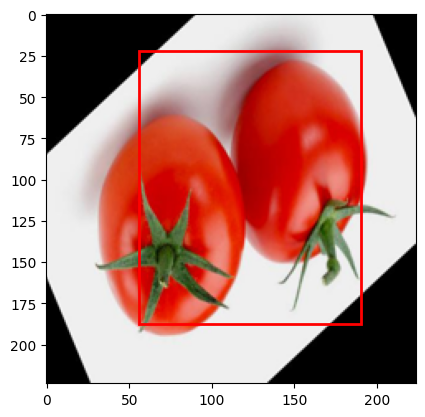

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

def predict_image(img_path, model, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    class_pred, bbox_pred = model.predict(img)
    class_id = np.argmax(class_pred)
    return class_id, bbox_pred

def display_image_with_bbox(img_path, bbox, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Bounding box coordinates
    x_min, y_min, x_max, y_max = bbox[0]
    width = x_max - x_min
    height = y_max - y_min

    # Create a Rectangle patch
    rect = patches.Rectangle((x_min * target_size[0], y_min * target_size[1]),
                             width * target_size[0], height * target_size[1],
                             linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

# Path to the image
img_path = '/content/dataset/train/istockphoto-1126929591-612x612_jpg.rf.09e1e2f9a743fcedbc1bb7a2dcf67a7d.jpg'
target_size = (224, 224)

# Predict class and bounding box
class_id, bbox_pred = predict_image(img_path, model, target_size)
predicted = items[class_id]
print(f"Predicted Class: {predicted}, Bounding Box: {bbox_pred}")

# Display the image with bounding box
display_image_with_bbox(img_path, bbox_pred, target_size)
